## Imports

In [1]:
# utils
import os
import sys
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# metrics
from utils import config
from utils.plot.plot import GeneratePlots
from utils.reader import read_file_yaml
from utils.utils import get_last_modification_directory, set_params

np.random.seed(0)

## Reading datasets

In [2]:
path_outputs_url = PROJECT_DIR / "outputs"
path_data_url = PROJECT_DIR / "data"
file_path_parameters = PROJECT_DIR / "conf" / "parameters.yml"
parameters = read_file_yaml(file_path_parameters)
path_results_url = PROJECT_DIR / parameters["results"]["filepath"]

n_random = np.sort(
    [int(i.replace("random_n", "")) for i in os.listdir(path_results_url) if ".placehold" not in i]
)
path_random = ["random_n" + str(i) for i in n_random]
path_results = [path_results_url / i for i in path_random]

_, path_random = get_last_modification_directory(path_results, path_random, parameters)

ext_type = parameters["outputs"]["extension_type"]
ext_local_img = parameters["outputs"]["extension_local_img"]
ext_best_img = parameters["outputs"]["extension_best_img"]

In [3]:
path_data = {i: path_data_url / i for i in config.file_names}
path_params = {i: {j: path_results_url / i / j / "params" for j in config.file_names} for i in path_random}

In [4]:
data = {
    i_name: pd.read_csv(i_url / Path(i_name + f"{ext_type}"))
    if f"{i_name}_pca{ext_type}" not in os.listdir(i_url)
    else pd.read_csv(i_url / Path(i_name + "_pca" + ext_type))
    for i_name, i_url in path_data.items()
}

In [5]:
params = {}
for i_random, i_content in path_params.items():
    params[i_random] = {}
    for j_name, j_content in i_content.items():
        params[i_random][j_name] = {}
        for which in ["abilities", "diff_disc"]:
            try:
                params[i_random][j_name][which] = pd.read_csv(j_content / Path(which + ext_type), index_col=0)
            except Exception:
                continue

## Plot of difficulties

In [6]:
figs = {}
for i_random, i_content in tqdm(list(params.items())):
    _plt_parameters = set_params(data, i_content)
    gp = GeneratePlots(data=data)
    fig, _ = gp.scatterplot_diff_disc(
        len(_plt_parameters.keys()), 2, plot_parameters=_plt_parameters, figsize=(20, len(config.file_names) + 12)
    )
    figs[i_random] = fig
    plt.close()

100%|██████████| 71/71 [00:57<00:00,  1.23it/s]


In [7]:
i_figs_unique = {}
for i in tqdm(config.file_names):
    i_figs_unique[i] = {}
    for i_random, i_content in list(params.items()):
        _plt_parameters = set_params({i: data[i]}, i_content)
        gp = GeneratePlots(data={i: data[i]})
        fig, _ = gp.scatterplot_diff_disc_unique(
            1, 2, plot_parameters={i: _plt_parameters[i]}, figsize=(22, 7)
        )
        i_figs_unique[i][i_random] = fig
        # plt.close()

100%|██████████| 9/9 [01:15<00:00,  8.44s/it]


In [68]:
params_general = {
    "nrows": 1,
    "ncols": 1,
    "figsize": (10, 8),
    "fontsize": 26
}
i_figs_unique_param = {}
axs = {}
for i in ["varied", "breast_cancer"]:#tqdm(config.file_names):
    i_figs_unique_param[i] = {}
    axs[i] = {}
    for i_random, i_content in list(params.items()):
        _plt_parameters = set_params({i: data[i]}, i_content)
        gp = GeneratePlots(data={i: data[i]})
        params_general.update({"plot_parameters": _plt_parameters[i]})
        if i not in ["wine", "iris", "breast_cancer", "diabetes", "digits"]:
            params_general.update({"xlabel": r"$x_{1}$", "ylabel": r"$x_{2}$"})
        fig, axs[i][i_random] = gp.scatterplot(
            **params_general
        )
        if i not in ["wine", "iris", "breast_cancer", "diabetes", "digits"]:
            del params_general["xlabel"]
            del params_general["ylabel"]
        i_figs_unique_param[i][i_random] = fig
        # plt.close()

In [69]:
selected = "varied"
_param = params["random_n0"]
_plt_parameters = set_params({selected: data[selected]}, _param)
idx_most_difficulty = _plt_parameters[selected][0][2]["c"][_plt_parameters[selected][0][2]["c"] == _plt_parameters[selected][0][2]["c"].max()].index[0]
idx_minor_difficulty = _plt_parameters[selected][0][2]["c"][_plt_parameters[selected][0][2]["c"] == _plt_parameters[selected][0][2]["c"].min()].index[0]

x, y = data[selected].loc[idx_most_difficulty, :].values[:2]
axs[selected]["random_n0"].annotate(
    'Maximum difficulty',
    xy=(x, y),
    xytext=(x + 0.5, y + 0.3),
    arrowprops=dict(
        arrowstyle='->',
        color='Red',
        lw=2
    ),
    fontsize=12,
    color='black'
)
x, y = data[selected].loc[idx_minor_difficulty, :].values[:2]
axs[selected]["random_n0"].annotate(
    'Minimum difficulty',
    xy=(x, y),
    xytext=(x - 0.5, y + 1),
    arrowprops=dict(
        arrowstyle='->',
        color='blue',
        lw=2
    ),
    fontsize=12,
    color='black'
)

Text(0.8114500116113268, 1.6796166795093679, 'Minimum difficulty')

In [75]:
print(path_outputs_url / Path(selected + "_random_n0" + "_arrow"  + ext_local_img))
i_figs_unique_param[selected]["random_n0"]["difficulties"].savefig(
    path_outputs_url / Path(selected + "_random_n0" + "_arrow"  + ext_local_img),
    format=ext_local_img[1:],
    **parameters["outputs"]["args"]
)

/home/manuel/projects/papers/claire/outputs/varied_random_n0_arrow.png


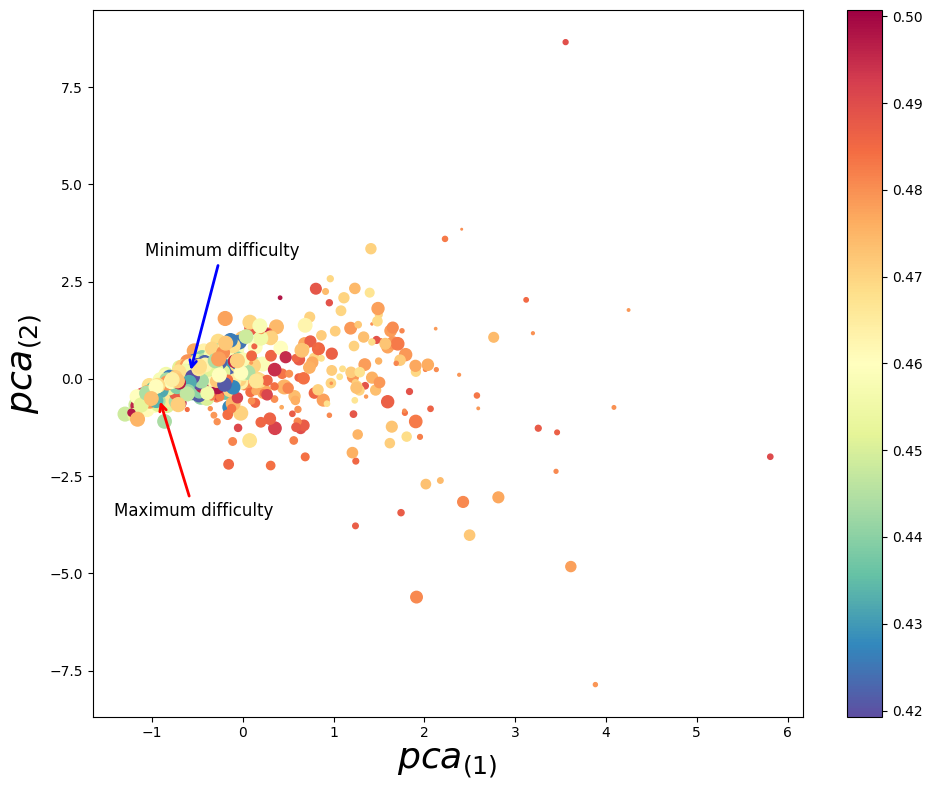

In [76]:
selected = "breast_cancer"
_param = params["random_n0"]
_plt_parameters = set_params({selected: data[selected]}, _param)
idx_most_difficulty = _plt_parameters[selected][0][2]["c"][_plt_parameters[selected][0][2]["c"] == _plt_parameters[selected][0][2]["c"].max()].index[0]
idx_minor_difficulty = _plt_parameters[selected][0][2]["c"][_plt_parameters[selected][0][2]["c"] == _plt_parameters[selected][0][2]["c"].min()].index[0]

x, y = data[selected].loc[idx_most_difficulty, :].values[:2]
axs[selected]["random_n0"].annotate(
    'Maximum difficulty',
    xy=(x, y),
    xytext=(x - 0.5, y - 3),
    arrowprops=dict(
        arrowstyle='->',
        color='Red',
        lw=2
    ),
    fontsize=12,
    color='black'
)
x, y = data[selected].loc[idx_minor_difficulty, :].values[:2]
axs[selected]["random_n0"].annotate(
    'Minimum difficulty',
    xy=(x, y),
    xytext=(x - 0.5, y + 3),
    arrowprops=dict(
        arrowstyle='->',
        color='blue',
        lw=2
    ),
    fontsize=12,
    color='black'
)
i_figs_unique_param[selected]["random_n0"]["difficulties"]

In [77]:
print(path_outputs_url / Path(selected + "_random_n0" + "_arrow"  + ext_local_img))
i_figs_unique_param[selected]["random_n0"]["difficulties"].savefig(
    path_outputs_url / Path(selected + "_random_n0" + "_arrow"  + ext_local_img),
    format=ext_local_img[1:],
    **parameters["outputs"]["args"]
)

/home/manuel/projects/papers/claire/outputs/breast_cancer_random_n0_arrow.png


## Save

In [ ]:
for i_random, i_content in tqdm(figs.items()):
    i_content.savefig(
        path_outputs_url / Path(i_random + "_" + "diff_disc_all" + ext_best_img), format=ext_best_img[1:]
    )  # eps format
    i_content.savefig(
        path_outputs_url / Path(i_random + "_" + "diff_disc_all" + ext_local_img), format=ext_local_img[1:],
        **parameters["outputs"]["args"]
    )  # png format

In [ ]:
for i_name, i_content in tqdm(list(i_figs_unique_param.items())):
    for j_random, j_content in list(i_content.items())[:1]:
        for which_param, k_figure in j_content.items():
            k_figure.savefig(
                path_outputs_url / Path(i_name + "_" + j_random + "_" + which_param + ext_best_img),
                format=ext_best_img[1:]
            )  # eps format
            k_figure.savefig(
                path_outputs_url / Path(i_name + "_" + j_random + "_" + which_param + ext_local_img),
                format=ext_local_img[1:],
                **parameters["outputs"]["args"]
            )  # png format